# Performance Evaluation

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

# Regression Performance
- MAE (mean absolute error)
- MSE (mean square error)
- RMSE (root mean square error)
- R-squared



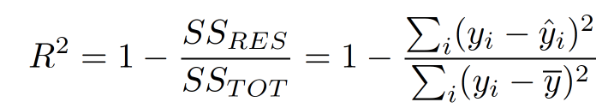

# Classification Performance
- 분류 알고리즘 비교
  - 리지 규제, 라쏘 규제
  - 교차검증
  - 정적 성능평가 Confusion matrix  
  - 동적 성능평가 ROC

- Data
  - 포도주 품질 분류 https://goo.gl/Gyc8K7
  - https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine/notebook



## Data (포도주 품질 평가 데이터)

In [13]:
!curl -L https://goo.gl/Gyc8K7 -o winequality-red.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   136  100   136    0     0    338      0 --:--:-- --:--:-- --:--:--   338
100    17  100    17    0     0     13      0  0:00:01  0:00:01 --:--:--     0
100   98k  100   98k    0     0  51674      0  0:00:01  0:00:01 --:--:-- 51674


In [14]:
wine = pd.read_csv('./winequality-red.csv')
print(wine.shape)
wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- fixed acidity - 결합 산도
- volatile acidity - 휘발성 산도
- citric acid - 시트르산
- residual sugar - 잔류 설탕
- chlorides	 - 염화물
- free sulfur dioxide - 자유 이산화황
- total sulfur dioxide - 총 이산화황
- density - 밀도
- pH - pH
- sulphates - 황산염
- alcohol - 알코올
- quality - 품질 (0 ~ 10 점)

In [15]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [16]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Preprocessing (Label 만들기)

In [17]:
wine['quality'].value_counts()

,count
quality,
5,681
6,638
7,199
4,53
8,18
3,10


In [18]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
my_bins = (2.5, 6.5, 8.5)
groups = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = my_bins, labels = groups)

wine['qual'].value_counts()

,count
qual,
0,1382
1,217


In [19]:
X = wine.drop(['quality', 'qual'], axis = 1)
y = wine['qual']

y.value_counts()

,count
qual,
0,1382
1,217


In [20]:
X[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


## Standard Scaling (표준 스케일링)
- transform the dataset to Gaussian dist (0, 1) - numerical features only
- test dataset should also be scaled

In [21]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1279, 11), (1279,), (320, 11), (320,))

In [25]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)  # fit and transform
X_test_sc = sc.transform(X_test)        # transform

In [24]:
X_train_sc[:3]

array([[ 0.43927889, -0.71740501,  1.52346841,  1.57792593, -0.16500466,
        -0.94501345, -0.80797173, -0.12436029, -0.19289163, -0.52182082,
         1.94168339],
       [-0.4753938 , -0.10089638, -1.29104916, -0.60799167, -0.08061359,
        -0.27530945, -0.46990413, -0.73199666,  0.32649447, -0.69949643,
         0.07911196],
       [-1.16139832, -0.94158996, -0.42110736,  0.52265537, -0.27049349,
        -0.08396546, -0.22403677, -0.6147335 ,  1.62495973, -0.81794684,
         2.12794053]])

## Linear model (Stochastic Gradient Descent method)

In [26]:
sgd = SGDClassifier()
sgd.fit(X_train_sc, y_train)
sgd.score(X_test_sc,y_test)

0.840625

## Decesion Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train_sc, y_train)
clf.score(X_train_sc,y_train), clf.score(X_test_sc,y_test)

(0.9335418295543393, 0.878125)

## Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, max_depth=5)
rfc.fit(X_train_sc, y_train)
rfc.score(X_train_sc,y_train), rfc.score(X_test_sc,y_test)

(0.9296325254104769, 0.88125)

## Support Vector Classifier (SVC)

In [29]:
svc = SVC()   # default: C=1.0, kernel='rbf', gamma='scale'
svc.fit(X_train_sc, y_train)
svc.score(X_train_sc,y_train), svc.score(X_test_sc,y_test)

(0.8991399530883503, 0.884375)

Logistic Regression
--

In [30]:
log = LogisticRegression()
log.fit(X_train_sc, y_train)
log.score(X_train_sc,y_train), log.score(X_test_sc,y_test)

(0.8819390148553558, 0.86875)

##  Performance : 정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [40]:
y_pred = sgd.predict(X_test_sc)
confusion_matrix(y_test, y_pred)

array([[269,   0],
       [ 51,   0]])

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       269
           1       0.00      0.00      0.00        51

    accuracy                           0.84       320
   macro avg       0.42      0.50      0.46       320
weighted avg       0.71      0.84      0.77       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Score (or Probability)

In [42]:
y_score = sgd.decision_function(X_test)   # sgd 는 predict_proba() 가 없음
# decision_function(): The confidence score for a sample is the signed distance
# of that sample to the hyperplane (proportional to the signed distance of that
# sample to the hyperplane)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


In [43]:
y_score[:5]

array([ -7.54243514,  -9.18298826, -21.89247532, -16.46035608,
       -28.66853855])

## Ranking (순서를 평가)

In [44]:
result = pd.DataFrame(list(zip(y_score, y_test)),
                      columns=['score', 'real'])
result.head()

,score,real
0,-7.542435,0
1,-9.182988,0
2,-21.892475,0
3,-16.460356,0
4,-28.668539,0


## ROC and AUC (맞춘 순서로 평가)

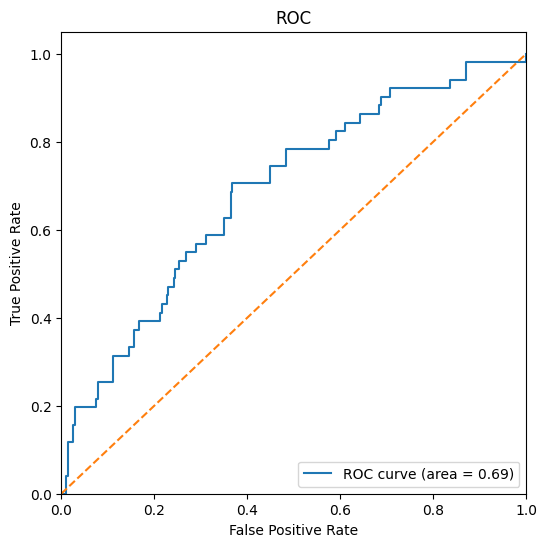

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

## Precision-Recall curve

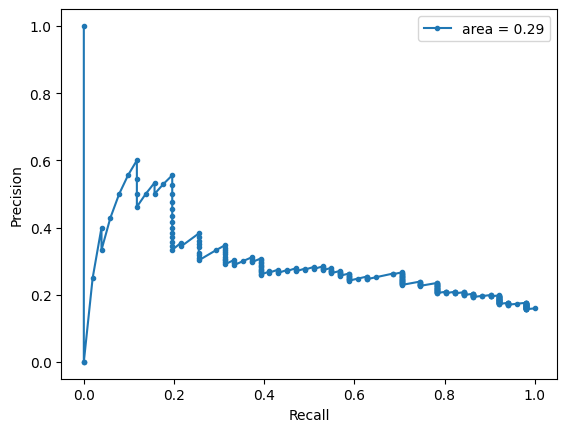

In [46]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_score = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='area = %0.2f' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()